In [107]:
import gym
import haiku as hk
import jax
import jax.numpy as jnp
import jax.nn as nn
import jax.random as random
import numpy as np
import optax
import matplotlib.pyplot as plt
import pickle as pkl
import sys
from jax import tree_map
from jax import grad, value_and_grad
from jax import lax
from jax import jit
from tqdm import tqdm
from collections import namedtuple
%matplotlib inline 

In [108]:
def pol_model(observation):
  mlp = hk.Sequential(
      [
       hk.Linear(32), nn.relu,
       hk.Linear(2)
      ]
  )
  return mlp(observation)

In [109]:

def val_model(observation):
  mlp = hk.Sequential(
      [
       hk.Linear(64), nn.relu,
       hk.Linear(1)
      ]
  )
  return mlp(observation)

In [120]:
def train():
  
  # Define training configurations and problem parameters
  NUM_EPISODE = 1000
  GAMMA = 0.99
  RECORD_INTERVAL = 10
  Record = namedtuple('Record',['r','discount','log_pol_grad','val_pred','val_grad'])
  
  # random key generator
  rng = hk.PRNGSequence(0)
  
  # actor and critic networks
  pol_net = hk.without_apply_rng(hk.transform(pol_model))
  val_net = hk.without_apply_rng(hk.transform(val_model))

  dummy_obs = jnp.array([0,0,0,0],dtype=jnp.float32)

  pol_params = pol_net.init(rng.next(), dummy_obs)
  val_params = val_net.init(rng.next(), dummy_obs)

  # make optimizers
  pol_opt = optax.adam(1e-5)
  val_opt = optax.adam(1e-4)

  pol_opt_state = pol_opt.init(pol_params)
  val_opt_state = val_opt.init(val_params)

  @jit
  def act(params, obs, rand):
    logits = pol_net.apply(params, obs)
    return random.categorical(rand, logits)
  
  # policy related functions
  @jit
  def pol_obj(params, obs, action, tde, discount):
    logits = pol_net.apply(params, obs)
    return discount*tde*nn.log_softmax(logits)[action]
  
  @jit
  def update_pol(params, opt_state, gradient):
    updates, new_opt_state = pol_opt.update(gradient, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state
  
#   @jit
#   def zero_tree(tree):
#     return tree_map(lambda x: 0*x, tree)
  
  
  # value function related functions
  @jit
  def val_obj(params, obs, target):
    v_t = val_net.apply(params, obs)
    tde = target - 
    return v_t[0]
  
  
  @jit
  def update_val_fn(params, opt_state, gradient, tde):
    gradient = tree_map(lambda g: tde*g, gradient)
    updates, new_opt_state = val_opt.update(gradient, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

  
  # environment
  env = gym.make('CartPole-v0')
  env.seed(1)
  
  # record containers
  episode_lengths = []
  avg_tde = []

  for eps in tqdm(range(NUM_EPISODE)):
    # initialization for each episode
    o_t = jnp.array(env.reset(), dtype=jnp.float32)
    done = False
    I = 1.0
    cumulative_tde = 0
    num_step = 0
    trajectory = []
    # interact with the environment
    while not done:
      likelihood_grad, action = grad(pol, has_aux=True)(pol_params, o_t, rng.next())
      prediction, val_gradient = value_and_grad(val_fn)(val_params, o_t)

      num_step += 1

      o_tp1, reward, done, _ = env.step(action.item())
      o_tp1 = jnp.array(o_tp1, dtype=jnp.float32)
      
      trajectory.append(Record(reward, I, likelihood_grad, prediction.item(), val_gradient))
      
      I = GAMMA*I
      o_t = o_tp1
    
    
    trajectory.reverse()
    ret = 0.0
    for record in trajectory:
      ret = GAMMA*ret + record.r
      tde = ret - record.val_pred
      val_params, val_opt_state = update_val_fn(val_params, val_opt_state, record.val_grad, tde)
      pol_params, pol_opt_state = update_pol(pol_params, pol_opt_state, record.log_pol_grad, tde, record.discount)
      cumulative_tde += abs(tde)
    
    
    # recording
    if eps % RECORD_INTERVAL == 0:
      episode_lengths.append(num_step)
      avg_tde.append(cumulative_tde/num_step)
    
  # save models
  with open('pol_param.pickle','wb') as fp:
    pkl.dump(pol_params, fp)

  with open('val_param.pickle','wb') as fp:
    pkl.dump(val_params, fp)
  
  return episode_lengths, avg_tde
 

  

In [121]:
def plot_figure(episode_lengths, avg_tde):
  plt.figure()
  plt.plot(episode_lengths,'b')
  plt.xlabel('episode/interval')
  plt.ylabel('length')
  plt.grid()
  
  plt.figure()
  plt.plot(avg_tde,'r')
  plt.xlabel('episode/interval')
  plt.ylabel('TD-error')
  plt.grid()

In [122]:
def test(episodes, render=False):
  GAMMA = 0.95
  # load parameters
  with open('actor_param.pickle','rb') as fp:
    actor_params = pkl.load(fp)
  with open('critic_param.pickle','rb') as fp:
    critic_params = pkl.load(fp)
  
  # create actor and critic
  actor = hk.without_apply_rng(hk.transform(policy_fn))
  critic = hk.without_apply_rng(hk.transform(val_fn))
  
  rng = hk.PRNGSequence(0)
  
  def act(obs, rng):
    logits = actor.apply(actor_params, obs)
    return random.categorical(rng, logits=logits).item()
  
  def pred(obs):
    return critic.apply(critic_params, obs).item()
  # make environment
  env = gym.make('CartPole-v0')
  env.seed(0)
  
  eps_lengths = []
  avg_tdes = []
  for eps in range(episodes):
    o_t = jnp.array(env.reset())
    done = False
    num_steps = 0
    total_tde = 0
    while not done:
      action = act(o_t, rng.next())
      
      o_tp1, reward, done, _ = env.step(action)
      num_steps += 1
      
      if render:
        env.render()
      
      total_tde += reward + GAMMA*pred(o_tp1) - pred(o_t)
      
      o_t = o_tp1
      
    
    eps_lengths.append(num_steps)
    avg_tdes.append(total_tde/num_steps)
  
  env.close()
  return eps_lengths, avg_tdes

In [123]:
def main():
  eps_len, avg_tde = train()
  plot_figure(eps_len, avg_tde)
#   eps_len, avg_tde = test(100)
#   plot_figure(eps_len, avg_tde)

100%|███████████████████████████████████████| 1000/1000 [01:23<00:00, 11.92it/s]


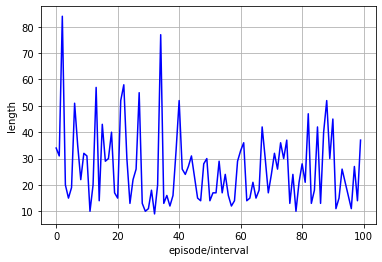

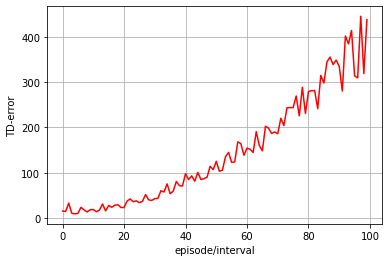

In [124]:
main()